# Setup

In [1]:
%cd ../

/kaggle


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 400)

# Data Collection

In [4]:
INPUTS_FOLDER = 'input/covid-19-nlp-text-classification/'
RANDOM_STATE = 42
TARGET = 'sentiment'
TEXT_FIELD = 'processed_tweet'

In [5]:
TRAIN_DATA = INPUTS_FOLDER + 'Corona_NLP_train.csv'
TEST_DATA = INPUTS_FOLDER + 'Corona_NLP_test.csv'

In [6]:
df_train = pd.read_csv(TRAIN_DATA, encoding='latin')

In [7]:
df_test = pd.read_csv(TEST_DATA, encoding='latin')

In [8]:
df_train.sample(5, random_state=RANDOM_STATE)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31089,34888,79840,Lagos,06-04-2020,Without the there would not be any problem whatsoever People are getting worried about the supply chain Prices for key food staples are starting to soar in some parts of the world via,Neutral
35564,39363,84315,NaN,09-04-2020,"Rice &amp; wheat prices surge amid fears Covid-19 lockdown may threaten global food security\r\r\nIncreased panic buying of food due to coronavirus lockdowns has led to price spikes for worldÂs two staple grains, rice&amp; wheat. Importers rushed to stockpile goods\r\r\n https://t.co/0qOv3jAp9m",Extremely Negative
144,3943,48895,NaN,16-03-2020,"When the government says to start social distancing, but you work retail so you can't just not talk to customers in the store lol fml I'm 100% going to catch covid-19",Positive
8202,12001,56953,irlande du nord,19-03-2020,"What the shops are doing is obeying the law of demand and supply. If we want an ethical distribution of essential consumer items, then we must look to socialism. ThatÂs what we had - with rationing - in WW2, under an ostensibly Conservative PM. #coronavirus #covid19UK #BorisOut",Positive
31720,35519,80471,"Zaria, Nigeria",07-04-2020,Kaduna State Task Force on Covid 19 led by the Deputy Governor Sabuwa Balarabe today met with representatives of dealers traders of food and other essential items in Sheik Gumi market to address the wanton hike on the prices of food items at this critical period,Negative


# Preprocessing

In [9]:
df_train.columns = [str(name).lower() for name in df_train.columns.tolist()]

In [10]:
df_test.columns = [str(name).lower() for name in df_test.columns.tolist()]

In [11]:
import re

In [12]:
def preprocess_text(text: str) -> str:
    # Converts all characters to lowercase
    text = text.lower()
    # Removes URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Removes all punctuation and special characters except apostrophes
    text = re.sub(r'[^\w\s\']', '', text)
    # Removes all numbers
    text = re.sub(r'\d+', '', text)
    # Removes extra whitespace
    text = ' '.join(text.split())
    return text

In [13]:
df_train[TEXT_FIELD] = df_train["originaltweet"].map(preprocess_text)

In [14]:
df_test[TEXT_FIELD] = df_test["originaltweet"].map(preprocess_text)

In [15]:
df_train.sample(5, random_state=RANDOM_STATE)

,username,screenname,location,tweetat,originaltweet,sentiment,processed_tweet
31089,34888,79840,Lagos,06-04-2020,Without the there would not be any problem whatsoever People are getting worried about the supply chain Prices for key food staples are starting to soar in some parts of the world via,Neutral,without the there would not be any problem whatsoever people are getting worried about the supply chain prices for key food staples are starting to soar in some parts of the world via
35564,39363,84315,NaN,09-04-2020,"Rice &amp; wheat prices surge amid fears Covid-19 lockdown may threaten global food security\r\r\nIncreased panic buying of food due to coronavirus lockdowns has led to price spikes for worldÂs two staple grains, rice&amp; wheat. Importers rushed to stockpile goods\r\r\n https://t.co/0qOv3jAp9m",Extremely Negative,rice amp wheat prices surge amid fears covid lockdown may threaten global food security increased panic buying of food due to coronavirus lockdowns has led to price spikes for worldâs two staple grains riceamp wheat importers rushed to stockpile goods
144,3943,48895,NaN,16-03-2020,"When the government says to start social distancing, but you work retail so you can't just not talk to customers in the store lol fml I'm 100% going to catch covid-19",Positive,when the government says to start social distancing but you work retail so you can't just not talk to customers in the store lol fml i'm going to catch covid
8202,12001,56953,irlande du nord,19-03-2020,"What the shops are doing is obeying the law of demand and supply. If we want an ethical distribution of essential consumer items, then we must look to socialism. ThatÂs what we had - with rationing - in WW2, under an ostensibly Conservative PM. #coronavirus #covid19UK #BorisOut",Positive,what the shops are doing is obeying the law of demand and supply if we want an ethical distribution of essential consumer items then we must look to socialism thatâs what we had with rationing in ww under an ostensibly conservative pm coronavirus coviduk borisout
31720,35519,80471,"Zaria, Nigeria",07-04-2020,Kaduna State Task Force on Covid 19 led by the Deputy Governor Sabuwa Balarabe today met with representatives of dealers traders of food and other essential items in Sheik Gumi market to address the wanton hike on the prices of food items at this critical period,Negative,kaduna state task force on covid led by the deputy governor sabuwa balarabe today met with representatives of dealers traders of food and other essential items in sheik gumi market to address the wanton hike on the prices of food items at this critical period


# EDA

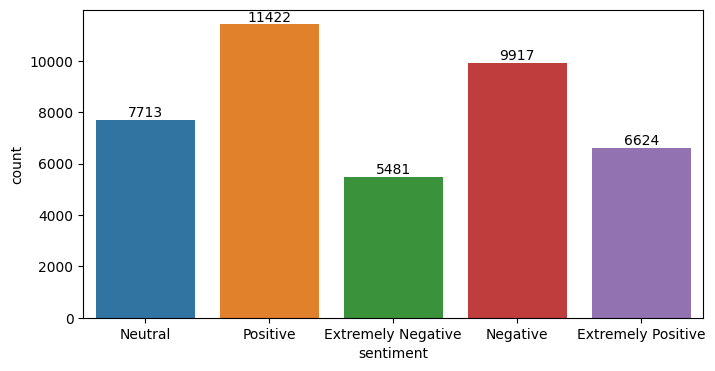

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.countplot(df_train, x=TARGET, ax=ax)
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', # Text to display (height of each bar)
        (p.get_x() + p.get_width() / 2, p.get_height()), # Position at the top center of each bar
        ha='center', # Center align horizontally
        va='bottom' # Align text slightly above the bar
    )
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


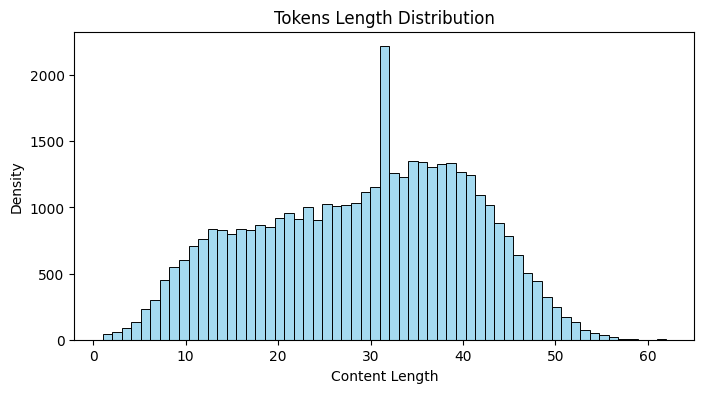

In [17]:
# Calculate the lengths of the content
lengths = [len(e) for e in df_train["processed_tweet"].str.split(" ").values]

# Plotting with Seaborn's kdeplot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.histplot(lengths, ax=ax, color='skyblue', fill=True)
ax.set_xlabel('Content Length')
ax.set_ylabel('Density')
ax.set_title('Tokens Length Distribution')

plt.show()

# Encoding target

In [18]:
sentiments = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2,
    "Extremely Positive": 3,
    "Extremely Negative": 4
}

In [19]:
df_train[TARGET] = df_train[TARGET].map(sentiments)

In [20]:
df_test[TARGET] = df_test[TARGET].map(sentiments)

# Modeling (ALBERT)

## Tokenizer

In [21]:
ALBERT_MODEL = "albert-base-v2"

In [22]:
from transformers import AlbertTokenizer

In [23]:
tokenizer = AlbertTokenizer.from_pretrained(ALBERT_MODEL)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
# Token lengths calculation
token_lens = []
for txt in df_train[TEXT_FIELD]:
    tokens = tokenizer.encode(text=txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


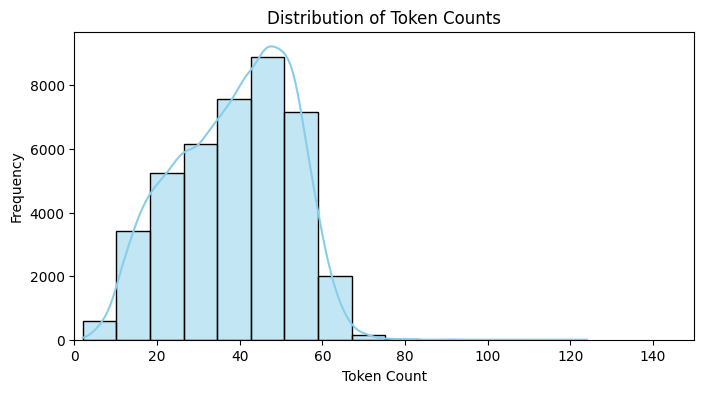

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_size_inches(8, 4)
sns.histplot(token_lens, bins=15, kde=True, color='skyblue', ax=ax)
ax.set_xlim([0, 150])
ax.set_xlabel('Token Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Token Counts')
plt.show()

In [26]:
MAX_LEN = 70

## Dataset Utility Class

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

In [28]:
BATCH_SIZE = 32

In [29]:
class CovidDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len, include_raw_text=False):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            text=tweet,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt'
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        
        if self.include_raw_text:
            output['tweet_text'] = tweet

        return output

In [30]:
def create_data_loader(df, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False):
    dataset = CovidDataset(
        tweets = df[TEXT_FIELD].to_list(),
        targets = df[TARGET].to_list(),
        tokenizer = tokenizer,
        max_len = max_len,
        include_raw_text = include_raw_text
    )
    return DataLoader(dataset=dataset, batch_size=batch_size)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = RANDOM_STATE)

In [33]:
print(df_train.shape, df_val.shape)

(32925, 7) (8232, 7)


In [34]:
train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=True)

In [35]:
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=True)

In [36]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [37]:
#Testing to see if the data loader works appropriately
data = next(iter(train_data_loader))

In [38]:
# Print the keys in the batch
print("Batch Keys:", data.keys())

# Print the shape of the 'input_ids' tensor
print(f"Shape of 'input_ids' tensor: {data['input_ids'].shape} (Batch Size, Max Length)")

# Print the shape of the 'attention_mask' tensor
print(f"Shape of 'attention_mask' tensor: {data['attention_mask'].shape} (Batch Size, Max Length)")

# Print the shape of the 'targets' tensor
print(f"Shape of 'targets' tensor: {data['targets'].shape} (Batch Size)")

Batch Keys: dict_keys(['input_ids', 'attention_mask', 'targets'])
Shape of 'input_ids' tensor: torch.Size([32, 70]) (Batch Size, Max Length)
Shape of 'attention_mask' tensor: torch.Size([32, 70]) (Batch Size, Max Length)
Shape of 'targets' tensor: torch.Size([32]) (Batch Size)


## Model Utility Class

In [39]:
from transformers import AlbertModel

In [40]:
model = AlbertModel.from_pretrained(ALBERT_MODEL)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

In [41]:
from torch import nn

In [42]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.albert = AlbertModel.from_pretrained(ALBERT_MODEL, return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.albert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.albert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
print(device)

cuda:0


In [45]:
model = SentimentClassifier(n_classes=len(sentiments))
model = model.to(device)

- A little test:

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [47]:
logits = model(input_ids, attention_mask)

In [48]:
import torch.nn.functional as F

In [49]:
probs = F.softmax( model(input_ids, attention_mask) , dim = 1)

In [50]:
max_values, max_indices = torch.max(probs, dim=1)

In [51]:
print("Probabilities:\n", probs)
print("\nSelected Max Values:\n", max_values)
print("\nIndices of Max Values:\n", max_indices)

Probabilities:
 tensor([[0.1546, 0.2515, 0.2483, 0.1597, 0.1859],
        [0.1164, 0.2500, 0.2289, 0.1053, 0.2995],
        [0.2115, 0.3056, 0.2520, 0.0828, 0.1482],
        [0.1136, 0.2320, 0.4299, 0.0538, 0.1706],
        [0.1499, 0.2132, 0.3505, 0.0789, 0.2075],
        [0.0904, 0.2853, 0.3173, 0.1484, 0.1585],
        [0.2057, 0.1896, 0.2877, 0.0884, 0.2286],
        [0.2547, 0.2172, 0.1369, 0.1218, 0.2694],
        [0.1208, 0.2970, 0.2447, 0.1279, 0.2096],
        [0.1103, 0.2865, 0.2973, 0.0936, 0.2123],
        [0.1366, 0.2073, 0.3573, 0.0993, 0.1995],
        [0.1268, 0.3266, 0.2326, 0.1269, 0.1871],
        [0.1433, 0.2436, 0.2395, 0.0686, 0.3050],
        [0.1408, 0.3857, 0.2778, 0.0463, 0.1495],
        [0.0899, 0.3817, 0.2820, 0.1210, 0.1255],
        [0.1131, 0.2505, 0.3128, 0.0802, 0.2434],
        [0.1222, 0.2637, 0.3132, 0.1678, 0.1332],
        [0.2036, 0.2017, 0.3176, 0.0880, 0.1890],
        [0.1092, 0.2171, 0.2823, 0.1644, 0.2271],
        [0.1584, 0.3497, 0.2091, 0

## Training

## Training Loop Utility Functions

In [52]:
from transformers import get_linear_schedule_with_warmup
from torch import optim

In [53]:
EPOCHS = 8

In [54]:
optimizer = optim.AdamW(model.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.1 * total_steps),
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [55]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model=model.train()

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets).cpu()
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses)

In [56]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)

In [57]:
from collections import defaultdict
from textwrap import wrap

Epoch 1/8
---------------
Train loss 1.190023444860855 accuracy 0.4924221634864807
Val loss 0.9051522388476734 accuracy 0.6582847237586975
Epoch 2/8
---------------
Train loss 0.6705564867534952 accuracy 0.7575094699859619
Val loss 0.5708222572886666 accuracy 0.793974757194519
Best model saved with significant improvement!
Epoch 3/8
---------------
Train loss 0.47332843367745275 accuracy 0.8356568217277527
Val loss 0.49687172940304114 accuracy 0.8258017301559448
Best model saved with significant improvement!
Epoch 4/8
---------------
Train loss 0.3425189382799397 accuracy 0.8862566351890564
Val loss 0.5482606594414674 accuracy 0.8242225646972656
Epoch 5/8
---------------
Train loss 0.2537241108494696 accuracy 0.920516312122345
Val loss 0.5801473497593588 accuracy 0.8339407444000244
Early stopping triggered. No significant improvement in validation loss for 2 epochs.


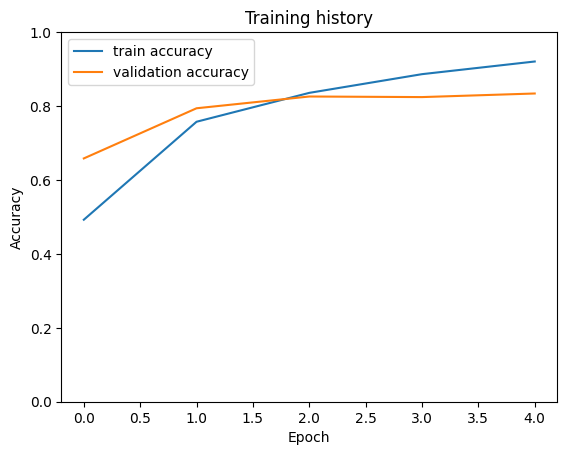

In [58]:
PATIENCE = 2  # Number of epochs to wait for improvement
epochs_no_improve = 0
IMPROVEMENT_THRESHOLD = 0.01  # Minimum improvement of 1% in validation loss

history = defaultdict(list)
best_val_loss = None  # Initialize best_val_loss as None

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 15)
    
    # Training step
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    # Validation step
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    
    # Record training history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Initialize best_val_loss after the first validation step
    if best_val_loss is None:
        best_val_loss = val_loss  # Set the first val_loss as the baseline best loss
    
    # Check if validation loss improved by at least the threshold percentage
    if val_loss < best_val_loss * (1 - IMPROVEMENT_THRESHOLD):
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_state.bin')  # Save the best model
        print("Best model saved with significant improvement!")
    else:
        epochs_no_improve += 1
    
    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered. No significant improvement in validation loss for {} epochs.".format(PATIENCE))
        break

# Plot training history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

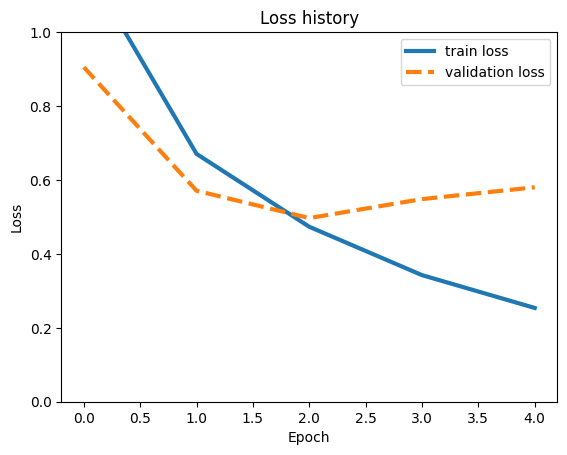

In [59]:
plt.plot(history['train_loss'], label='train loss',linewidth=3)
plt.plot(history['val_loss'], '--',label='validation loss',linewidth=3)

plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [60]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy {test_acc.item()}')

Test Accuracy 0.8122696280479431


- ALBERT without warmup: 0.807
- ALBERT with warmup: 0.812

# Model Evaluation

In [61]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [62]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

In [63]:
from sklearn.metrics import classification_report

In [64]:
sentiments

{'Positive': 0,
 'Negative': 1,
 'Neutral': 2,
 'Extremely Positive': 3,
 'Extremely Negative': 4}

In [65]:
class_names = list(sentiments.keys())

In [100]:
y_tweets_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

          Positive       0.79      0.78      0.78       947
          Negative       0.76      0.84      0.80      1041
           Neutral       0.87      0.77      0.82       619
Extremely Positive       0.86      0.85      0.86       599
Extremely Negative       0.85      0.82      0.84       592

          accuracy                           0.81      3798
         macro avg       0.83      0.81      0.82      3798
      weighted avg       0.82      0.81      0.81      3798



In [67]:
from sklearn.metrics import confusion_matrix

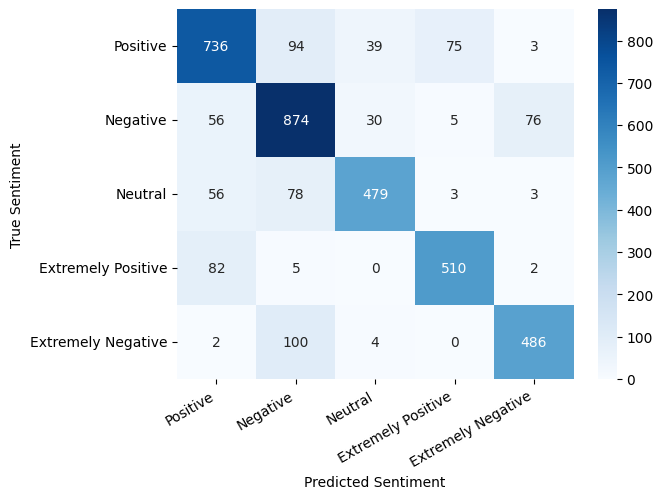

In [68]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [101]:
swapped_sentiments = {v: k for k, v in sentiments.items()}

In [108]:
idx = 42
tweet_text = y_tweets_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names':class_names, 'values':y_pred_probs[idx]})
predicted_sentiment = pred_df.loc[pred_df['values'].idxmax(), 'class_names']

print("\n".join(wrap(tweet_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')
print(f'Predicted Sentiment: {predicted_sentiment}')

global stock markets continued their bear run as dowjones and sampp
plunged as they opened on monday plunge was largely on the back of the
overnight slump in crudeoil prices along with the persistent concerns
over the impact of coronavirus on the global economy

True Sentiment: Neutral
Predicted Sentiment: Negative


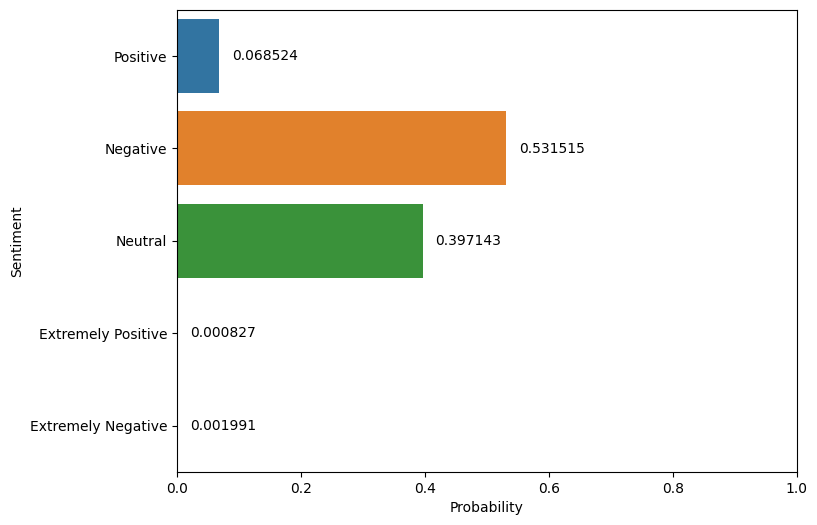

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

sns.barplot(x='values', y='class_names', data=pred_df, orient='h', ax=ax)
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1])

for index, row in pred_df.iterrows():
    ax.text(row['values'] + 0.02, index, f"{row['values']:.6f}", color='black', va="center")

plt.show()

In [114]:
tweet_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(
    text=tweet_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

In [115]:
print(f'Review text: {tweet_text}')
print(f'Predicted Sentiment: {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Predicted Sentiment: Extremely Positive
